# Dog Breed Classification Using Convolutional Neural Networks

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
import numpy as np
import math
import shutil

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import inception_v3

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


## Google Colab

In [4]:
!nvidia-smi

Tue Dec  2 07:13:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
images_dir = os.path.join(path, "images", "Images")

# Set this as your source directory
src_dir = images_dir

Using Colab cache for faster access to the 'stanford-dogs-dataset' dataset.


## Data Collection & Preperation

In [6]:
# run only locally

# original dataset path
# src_dir = 'StanfordDogsDataset/Images/images/'

In [7]:
# new dataset path
dst_dir = 'data/'

# create destination folder if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# get all dog breed categories
categories = os.listdir(src_dir)

for category in categories:
    # remove the numeric prefix and convert to lowercase
    cleaned_name = category.split('-', 1)[-1].lower()

    # create a folder for the dog breed
    breed_dst_path = os.path.join(dst_dir, cleaned_name)
    os.makedirs(breed_dst_path, exist_ok=True)

    # copy all images from the original folder to the cleaned folder
    category_src_path = os.path.join(src_dir, category)
    for file_name in os.listdir(category_src_path):
        src_file = os.path.join(category_src_path, file_name)
        dst_file = os.path.join(breed_dst_path, file_name)
        shutil.copy(src_file, dst_file)

120


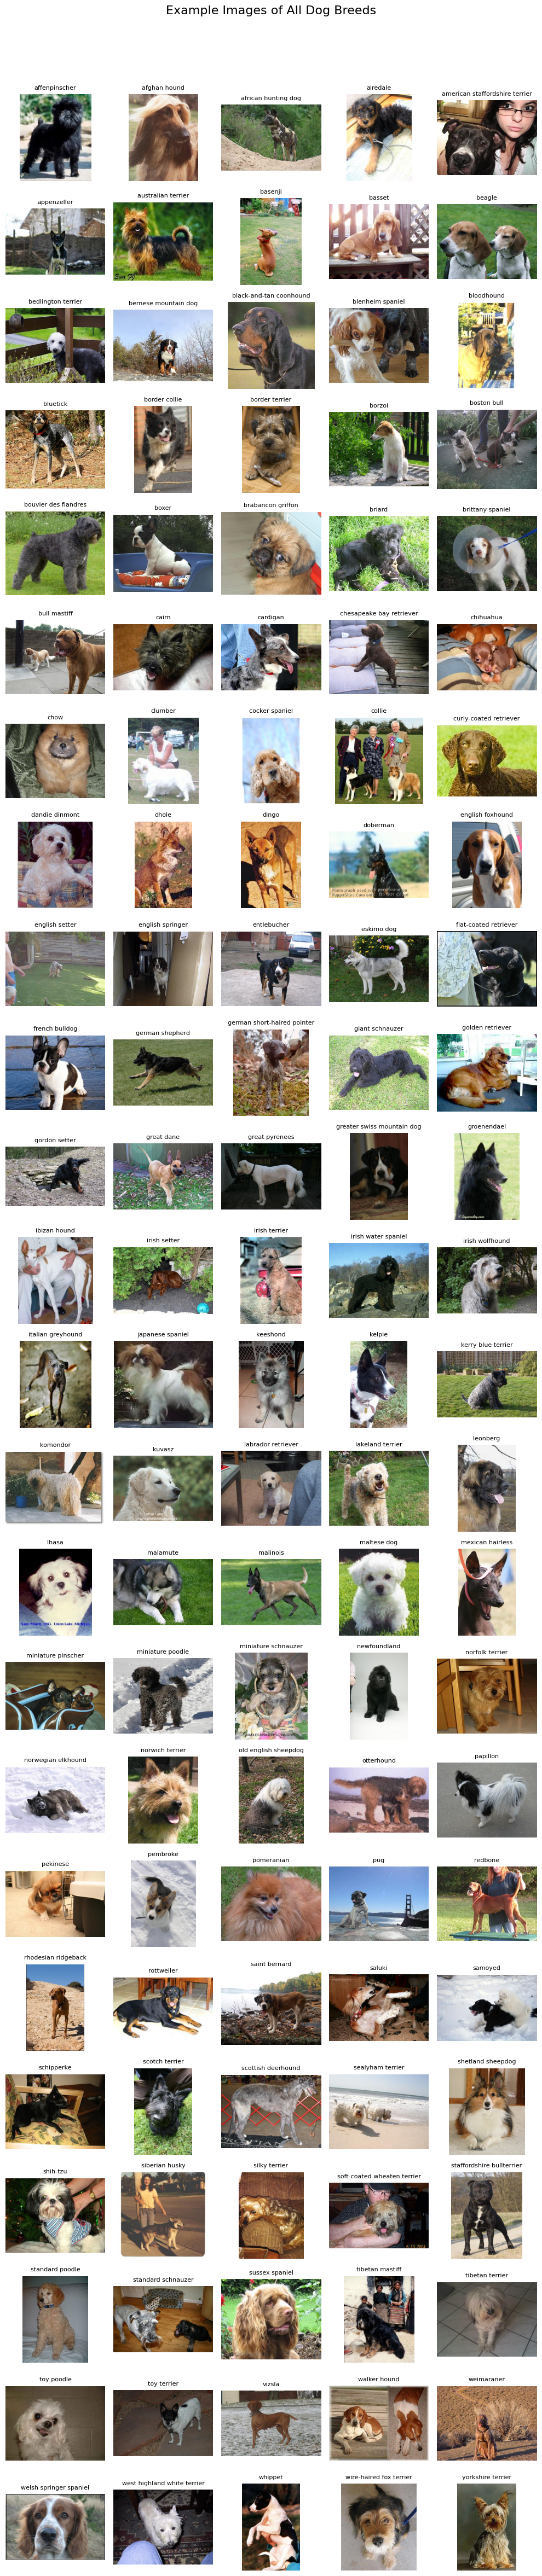

In [8]:
data_dir = 'data/'

# get all breeds
breeds = os.listdir(data_dir)
breeds.sort()  # optional: sort alphabetically
print(len(breeds))

# figure layout
num_breeds = len(breeds)
cols = 5  # number of columns per row
rows = math.ceil(num_breeds / cols)

fig = plt.figure(figsize=(cols * 2, rows * 2))
gs = gridspec.GridSpec(rows, cols)

# plot one image per breed
for idx, breed in enumerate(breeds):
    row = idx // cols
    col = idx % cols
    breed_path = os.path.join(data_dir, breed)
    image_list = os.listdir(breed_path)

    image = Image.open(os.path.join(breed_path, image_list[0])).convert('RGB')

    ax = fig.add_subplot(gs[row, col])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(breed.replace('_', ' '), fontsize=8)

plt.suptitle('Example Images of All Dog Breeds', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [9]:
# training transform with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# validation/test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [10]:
BATCH_SIZE = 32

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# override transforms for val/test
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# this function bundles up the training/testing loops from the previous notebook
def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    # make empty lists to keep track of the training and testing losses
    train_losses = []
    test_losses = []

    # loop through each epoch to run the training loop
    # and check the model with the training data
    # keep track of both sets of losses as your go
    for epoch in range(NUM_EPOCHS):

        # Run the training loop
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Run the testing loop
        # this is essentially the same as the training loop but
        # without the optimizer and backward propagation
        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} ")

    return(train_losses, test_losses)

Finally, let's redefine the cross entropy loss function

In [12]:
# cross entropy loss for use in classification problems
criterion = nn.CrossEntropyLoss()

In [13]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i]==0:
            correct +=1
        total += 1
    return(correct, total)

In [14]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # added third conv layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        conv_output_size = 64 * (32) * (32)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),

            # add a dropout layer here
            nn.Dropout(p=0.3),

            nn.Linear(128, 120)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [15]:
# scratch model
scratchModel = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(scratchModel.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 20

In [16]:
# call the training loop function we defined above
train_losses, test_losses = training_loop(scratchModel, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/20 - Train Loss: 4.7891, Train Correct: 155/16464 - Test Loss: 4.7857, Test Correct: 23/2058 
Epoch 2/20 - Train Loss: 4.7652, Train Correct: 233/16464 - Test Loss: 4.6652, Test Correct: 37/2058 
Epoch 3/20 - Train Loss: 4.6099, Train Correct: 383/16464 - Test Loss: 4.5294, Test Correct: 64/2058 
Epoch 4/20 - Train Loss: 4.5113, Train Correct: 522/16464 - Test Loss: 4.4893, Test Correct: 58/2058 
Epoch 5/20 - Train Loss: 4.4440, Train Correct: 613/16464 - Test Loss: 4.4662, Test Correct: 55/2058 
Epoch 6/20 - Train Loss: 4.3801, Train Correct: 762/16464 - Test Loss: 4.4368, Test Correct: 80/2058 
Epoch 7/20 - Train Loss: 4.2657, Train Correct: 901/16464 - Test Loss: 4.4048, Test Correct: 78/2058 
Epoch 8/20 - Train Loss: 4.0183, Train Correct: 1462/16464 - Test Loss: 4.4231, Test Correct: 89/2058 
Epoch 9/20 - Train Loss: 3.6253, Train Correct: 2381/16464 - Test Loss: 4.5367, Test Correct: 105/2058 
Epoch 10/20 - Train Loss: 3.1201, Train Correct: 3771/16464 - Test Loss: 4.8576

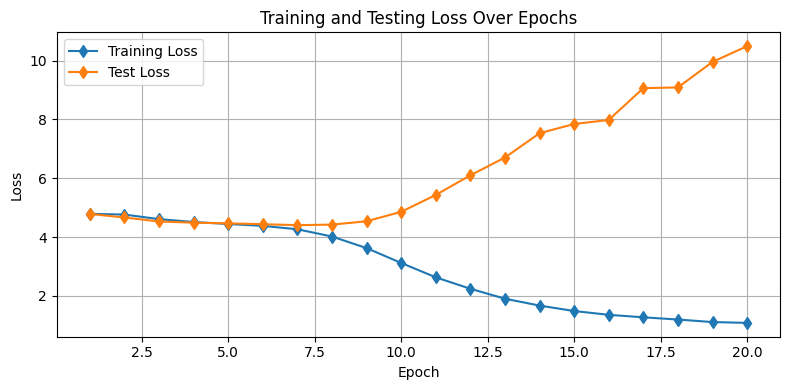

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# pretrained CNN
resnetModel = models.resnet18(pretrained=True)

# freeze all layers except the final fully connected layer
for param in resnetModel.parameters():
    param.requires_grad = False

# replace the final layer
resnetModel.fc = nn.Linear(resnetModel.fc.in_features, 120)
resnetModel = resnetModel.to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(resnetModel.parameters(), lr=0.001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# call the training loop function we defined above
train_losses, test_losses = training_loop(resnetModel, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/20 - Train Loss: 2.9345, Train Correct: 5074/16464 - Test Loss: 2.2837, Test Correct: 863/2058 
Epoch 2/20 - Train Loss: 2.0307, Train Correct: 7863/16464 - Test Loss: 2.1285, Test Correct: 930/2058 
Epoch 3/20 - Train Loss: 1.8065, Train Correct: 8705/16464 - Test Loss: 2.1155, Test Correct: 924/2058 
Epoch 4/20 - Train Loss: 1.6730, Train Correct: 9221/16464 - Test Loss: 2.1135, Test Correct: 946/2058 
Epoch 5/20 - Train Loss: 1.5779, Train Correct: 9490/16464 - Test Loss: 2.1332, Test Correct: 957/2058 
Epoch 6/20 - Train Loss: 1.5117, Train Correct: 9728/16464 - Test Loss: 2.1912, Test Correct: 949/2058 
Epoch 7/20 - Train Loss: 1.4520, Train Correct: 9872/16464 - Test Loss: 2.1892, Test Correct: 945/2058 
Epoch 8/20 - Train Loss: 1.3922, Train Correct: 10251/16464 - Test Loss: 2.2098, Test Correct: 946/2058 
Epoch 9/20 - Train Loss: 1.3471, Train Correct: 10328/16464 - Test Loss: 2.2619, Test Correct: 933/2058 
Epoch 10/20 - Train Loss: 1.3180, Train Correct: 10448/16464 -

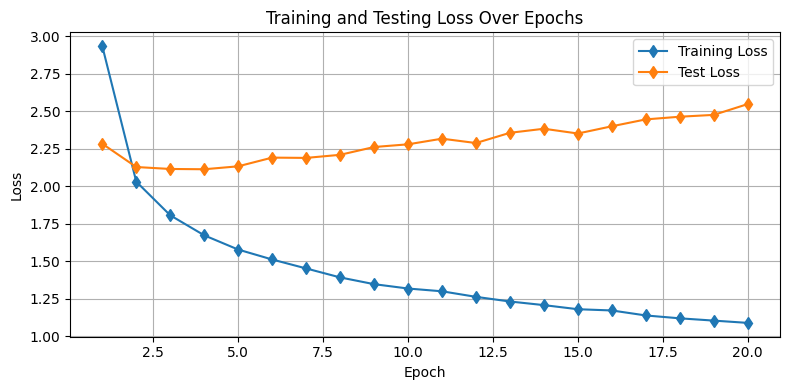

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Data for InceptionV3, requires 299x299

# training transform with augmentation
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# validation/test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

BATCH_SIZE = 32

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# override transforms for val/test
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
inceptionModel = inception_v3(weights="IMAGENET1K_V1")
inceptionModel.aux_logits = False

# freeze all pretrained layers
for param in inceptionModel.parameters():
    param.requires_grad = False

# replace final fully connected layer for 120 classes
inceptionModel.fc = nn.Linear(inceptionModel.fc.in_features, 120)

# only the new fc layer is trainable
inceptionModel.fc.requires_grad = True

# move model to GPU
inceptionModel = inceptionModel.to(device)

optimizer = optim.Adam(inceptionModel.parameters(), lr=0.001)

In [23]:
# call the training loop function we defined above
train_losses, test_losses = training_loop(inceptionModel, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/20 - Train Loss: 1.5931, Train Correct: 10788/16464 - Test Loss: 0.7897, Test Correct: 1624/2058 
Epoch 2/20 - Train Loss: 0.7508, Train Correct: 12964/16464 - Test Loss: 0.6694, Test Correct: 1653/2058 
Epoch 3/20 - Train Loss: 0.6533, Train Correct: 13272/16464 - Test Loss: 0.7425, Test Correct: 1617/2058 
Epoch 4/20 - Train Loss: 0.5949, Train Correct: 13495/16464 - Test Loss: 0.6780, Test Correct: 1663/2058 
Epoch 5/20 - Train Loss: 0.5529, Train Correct: 13683/16464 - Test Loss: 0.7036, Test Correct: 1637/2058 
Epoch 6/20 - Train Loss: 0.5321, Train Correct: 13714/16464 - Test Loss: 0.6825, Test Correct: 1649/2058 
Epoch 7/20 - Train Loss: 0.5059, Train Correct: 13836/16464 - Test Loss: 0.7242, Test Correct: 1638/2058 
Epoch 8/20 - Train Loss: 0.4971, Train Correct: 13862/16464 - Test Loss: 0.7241, Test Correct: 1661/2058 
Epoch 9/20 - Train Loss: 0.4751, Train Correct: 14028/16464 - Test Loss: 0.6834, Test Correct: 1683/2058 
Epoch 10/20 - Train Loss: 0.4528, Train Correc

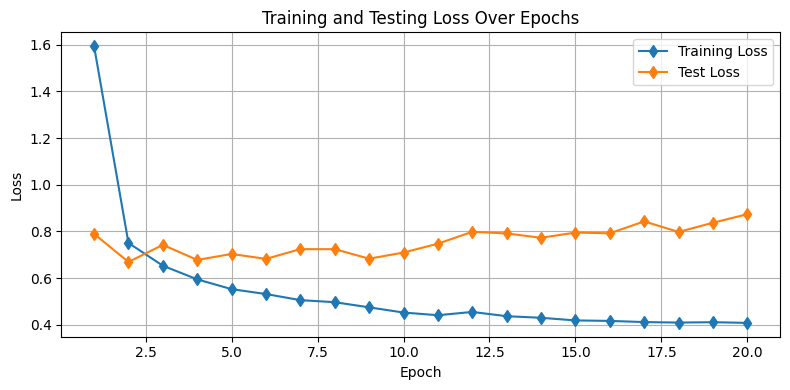

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()